<font size="4"><b>Оглавление </b></p></font> 
<a id='contents'></a>

1. [Постановка задания](#intro)
2. [Обзор данных](#data_review)
- [Выводы](#data_reviw_summary)
3. [Предобработка данных](#data_moderation)
- [Типы данных](#data_type)
- [Проверка явных дубликатов](#data_duplicates)
- [Обработка тарифов](#tariffs)
- [Выводы](#data_moderation_summary)
4. [Исследование данных](#data_research)
- [Выводы](#data_research_summary)
5. [Проверка гипотез](#hypothesis_check)
- [Гипотеза 1](#hypothesis_1)
- [Гипотеза 2](#hypothesis_2)
6. [Итоги исследования](#summary)

# **Определение перспективного тарифа для телеком-компании** 
<a id='intro'></a>

**Заказчик** — федеральный оператор сотовой связи «Мегалайн».

**Цель исследования**:
1. Сравнить два перспективных тарифных плана: «Смарт» и «Ультра» - на основании клиентской базы оператора для определения наиболее прибыльного.

**Поставленные задачи**
1. Изучить предоставленную базу данных клиентов и модели их потребительского поведения.
2. Сделать предварительный анализ тарифов на небольшой выборке клиентов.
3. Резюмировать анализ и выбрать лучшее решение для бизнеса, которое следует развивать среди клиентов.

**Дальнейшее использование**

Результаты исследования будут использоваться в дальнейшем при планировании бюджета компании на маркетинговые процессы и позволит сконцентрировать внимание на развитии наиболее выгодного и прибыльного тарифа. 

**Дополнительно предоставленная инфомарция о тарифах**

***Тариф «Смарт»***
- Ежемесячная плата, руб.	550	
- Включено: (мин/смс/Гб)	500/50/15	
- Сверх пакета, ру.: (мин/смс/Гб)	3/3/200	

***Тариф «Ультра»***
- Ежемесячная плата, руб.	1950	
- Включено: (мин/смс/Гб)	3000/1000/30	
- Сверх пакета, ру.: (мин/смс/Гб)	1/1/150

[К оглавлению](#contents)

## **I. Обзор данных** 
<a id='data_review'></a>

В ходе исследования нам понадобятся библиотеки:

* `pandas`
* `seaborn`
* `math`
* `matplotlib`
* `numpy`
* `scipy`
* `copy`
* `datetime`

Поэтому сразу импортируем их.

In [1]:
import pandas as pd

pd.options.display.float_format ='{:,.1f}'.format

import seaborn as sb

import math

import matplotlib.pyplot as plt

import numpy as np

from scipy import stats as st

import copy

from datetime import datetime

Сначала составим представление о полученных исходных данных.

Прочитаем исходные файлы с данными клиентов `calls.csv`, `internet.csv`, `messages.csv`, `tariffs.csv` и `users.csv` из папки `/datasets/` и сохраним их в одноименные переменные:

In [2]:
calls = pd.read_csv('/datasets/calls.csv')
internet = pd.read_csv('/datasets/internet.csv', index_col=0)
messages = pd.read_csv('/datasets/messages.csv')
tariffs = pd.read_csv('/datasets/tariffs.csv')
users = pd.read_csv('/datasets/users.csv')

#сохраним все в единую пемеренную `df`:
df = {
    'users':users,
    'calls': calls, 
    'messages':messages,
    'internet': internet, 
    'tariffs':tariffs
}

Выведем на экран первые пять строк таблицы:

In [3]:
for data in df:
    print('\n\t\033[4m\033[1m\033[31m{}\033[0m'.format(data))
    display(df.get(data).head())
    print('_' * 120)


	users


,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff
0,1000,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
1,1001,41,NaN,Москва,Иван,Ежов,2018-11-01,smart
2,1002,59,NaN,Стерлитамак,Евгений,Абрамович,2018-06-17,smart
3,1003,23,NaN,Москва,Белла,Белякова,2018-08-17,ultra
4,1004,68,NaN,Новокузнецк,Татьяна,Авдеенко,2018-05-14,ultra


________________________________________________________________________________________________________________________

	calls


,id,call_date,duration,user_id
0,1000_0,2018-07-25,0.0,1000
1,1000_1,2018-08-17,0.0,1000
2,1000_2,2018-06-11,2.9,1000
3,1000_3,2018-09-21,13.8,1000
4,1000_4,2018-12-15,5.2,1000


________________________________________________________________________________________________________________________

	messages


,id,message_date,user_id
0,1000_0,2018-06-27,1000
1,1000_1,2018-10-08,1000
2,1000_2,2018-08-04,1000
3,1000_3,2018-06-16,1000
4,1000_4,2018-12-05,1000


________________________________________________________________________________________________________________________

	internet


,id,mb_used,session_date,user_id
0,1000_0,113.0,2018-11-25,1000
1,1000_1,"1,052.8",2018-09-07,1000
2,1000_2,"1,197.3",2018-06-25,1000
3,1000_3,550.3,2018-08-22,1000
4,1000_4,302.6,2018-09-24,1000


________________________________________________________________________________________________________________________

	tariffs


,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,tariff_name
0,50,15360,500,550,200,3,3,smart
1,1000,30720,3000,1950,150,1,1,ultra


________________________________________________________________________________________________________________________


И получим общую информацию: <a id='info'></a>

In [4]:
for data in df:
    print('\t\t\033[4m\033[1m\033[31m{}\033[0m'.format(data), '\n')
    display(df.get(data).info())
    print('*' * 50)

		users 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   user_id     500 non-null    int64 
 1   age         500 non-null    int64 
 2   churn_date  38 non-null     object
 3   city        500 non-null    object
 4   first_name  500 non-null    object
 5   last_name   500 non-null    object
 6   reg_date    500 non-null    object
 7   tariff      500 non-null    object
dtypes: int64(2), object(6)
memory usage: 31.4+ KB


None

**************************************************
		calls 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202607 entries, 0 to 202606
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   id         202607 non-null  object 
 1   call_date  202607 non-null  object 
 2   duration   202607 non-null  float64
 3   user_id    202607 non-null  int64  
dtypes: float64(1), int64(1), object(2)
memory usage: 6.2+ MB


None

**************************************************
		messages 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123036 entries, 0 to 123035
Data columns (total 3 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   id            123036 non-null  object
 1   message_date  123036 non-null  object
 2   user_id       123036 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 2.8+ MB


None

**************************************************
		internet 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 149396 entries, 0 to 149395
Data columns (total 4 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   id            149396 non-null  object 
 1   mb_used       149396 non-null  float64
 2   session_date  149396 non-null  object 
 3   user_id       149396 non-null  int64  
dtypes: float64(1), int64(1), object(2)
memory usage: 5.7+ MB


None

**************************************************
		tariffs 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 8 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   messages_included      2 non-null      int64 
 1   mb_per_month_included  2 non-null      int64 
 2   minutes_included       2 non-null      int64 
 3   rub_monthly_fee        2 non-null      int64 
 4   rub_per_gb             2 non-null      int64 
 5   rub_per_message        2 non-null      int64 
 6   rub_per_minute         2 non-null      int64 
 7   tariff_name            2 non-null      object
dtypes: int64(7), object(1)
memory usage: 256.0+ bytes


None

**************************************************


Итак, мы имеем следующие данные и информацию о них согласно исходной документации: 
    
**1. Таблица `users` (информация о пользователях):** 

* `user_id` — уникальный идентификатор пользователя
* `first_name`— имя пользователя
* `last_name` — фамилия пользователя
* `age` — возраст пользователя в годах
* `reg_date` — дата подключения тарифа (день, месяц, год)
* `churn_date` — дата прекращения пользования тарифом (если значение пропущено, то тариф ещё действовал на момент выгрузки данных)
* `city` — город проживания пользователя
* `tariff` — название тарифного плана

Типы данных в столбцах — целые числа `int` и строки `object`.

**2. Таблица `calls` (информация о звонках):** 

* `id` — уникальный номер звонка
* `call_date` — дата звонка
* `duration` — длительность звонка в минутах
* `user_id` — идентификатор пользователя, сделавшего звонок

Типы данных в столбцах — целые числа `int`, вещественные числа `float` и строки `object`.

**3. Таблица `messages` (информация о сообщениях):**

* `id` — уникальный номер сообщения
* `message_date` — дата сообщения
* `user_id` — идентификатор пользователя, отправившего сообщение

Типы данных в столбцах — целые числа `int` и строки `object`.

**4. Таблица `internet` (информация об интернет-сессиях):**

* `id` — уникальный номер сессии
* `mb_used` — объём потраченного за сессию интернет-трафика (в мегабайтах)
* `session_date` — дата интернет-сессии
* `user_id` — идентификатор пользователя

Типы данных в столбцах — целые числа `int`, вещественные числа `float` и строки `object`.

**5. Таблица `tariffs` (информация о тарифах):**

* `tariff_name` — название тарифа
* `rub_monthly_fee` — ежемесячная абонентская плата в рублях
* `minutes_included` — количество минут разговора в месяц, включённых в абонентскую плату
* `messages_included` — количество сообщений в месяц, включённых в абонентскую плату
* `mb_per_month_included` — объём интернет-трафика, включённого в абонентскую плату (в мегабайтах)
* `rub_per_minute` — стоимость минуты разговора сверх тарифного пакета (например, если в тарифе 100 минут разговора в месяц, то со 101 минуты будет взиматься плата)
* `rub_per_message` — стоимость отправки сообщения сверх тарифного пакета
* `rub_per_gb` — стоимость дополнительного гигабайта интернет-трафика сверх тарифного пакета (1 гигабайт = 1024 мегабайта)

Типы данных в столбцах — целые числа `int` и строки `object`.

Среди всех датастов в глаза бросается сразу:
- неравное количество значений в `churn_date`, что можно объяснить продолжением пользованием тарифом клиентом на момент выгрузки; эти пропуски удалять не будем;
- разное количество предоставленной информации по пользователям (в каждом датасете, за исключением данных и тарифах, есть уникальный идентификатор пользователя);
- в таблице `calls` столбцы `duration` имеют нулевые значения, что свидетельствует о пропущенных звонках;
- в таблице `internet` данные были выгружены с указанием индекса, что генерировало дополнительный столбец `Unnamed`, не представляющий никакой ценной информации;
- по правилам оператора связи надо будет округлить значения в большую сторону до минут и Мб. Нулевые значения заменим на 1;
- интернет трафик переведем в Гб для удобства дальнейшей обработки.
    
**Для второго разночтения будем придерживаться следующей логики:** <a id='logic'></a>
* <span style="color: #4682B4; font-weight: 600"> Некоторые клиенты пользовались не всеми услугами: кто-то только звонками (подавляющее большинство значений).</span>

В последующем для анализа нам потребуется объединить данные из нескольких датасетов для создания выборки и проведения исследования, поэтому **образовавшиеся в процессе слияния пропуски мы заполним нулями**, основываясь принятой логике. 

В названиях колонок нарушений стиля не замечено.

[К оглавлению](#contents)

### **Выводы** 
<a id='data_reviw_summary'></a>

В предоставленных исходных данных хранится инфомармация о пользователях, их трафике и пользованием различными услугами оператора связи, а также описание тарифов. Все данные разбиты на несколько датафреймов, объединенные уникальным идентификатором. 

Предварительно можно утверждать, что данных достаточно для исследования и решения поставленных задач. Однако первично потребуется преобразовать исходные данные для последующего анализа:
1. В столбцах с датами `churn_date`, `reg_date`, `session_date`, `message_date`, `call_date`необходимо будет заменить тип данных на `datetime` вместо `object` для обработки;
2. По правилам оператора связи нужно округлить значения времени до минут и интернет трафик до Мб в большую сторону; нулевые значения при этом заменить на 1, а Мб перевести в Гб для удобства дальнейшего анализа; при этом для веб-трафика отдельные сессии не считаются. Вместо этого общая сумма за месяц округляется в бо́льшую сторону;
3. Объединить информацию по пользователям из нескольких датафреймов по `user_id` и устранить пропуски путем замены их на нуль на основании ранее описанной логики: некоторые клиенты пользовались не всеми услугами;

[К оглавлению](#contents)

## **II. Предобработка данных** 
<a id='data_moderation'></a>

### 1. Типы данных 
<a id='data_type'></a>

Согласно ранее поставленным задачам выполним сперва преобразование типов данных.

Для этого сначала переведем **столбцы с датами** `churn_date`, `reg_date`, `call_date`, `message_date`, `session_date` с типа `object` на **`datetime`**.

In [5]:
# check

users['churn_date'] = users['churn_date'].fillna('2018-12-31')

In [6]:
# check

col = {'call_date':calls,
                       'session_date':internet,
                       'message_date':messages,
                       'reg_date':users,
                       'churn_date':users
                       }

for _, data in col.items():
    data[_] = pd.to_datetime(data[_],format = '%Y-%m-%d')

In [7]:
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   user_id     500 non-null    int64         
 1   age         500 non-null    int64         
 2   churn_date  500 non-null    datetime64[ns]
 3   city        500 non-null    object        
 4   first_name  500 non-null    object        
 5   last_name   500 non-null    object        
 6   reg_date    500 non-null    datetime64[ns]
 7   tariff      500 non-null    object        
dtypes: datetime64[ns](2), int64(2), object(4)
memory usage: 31.4+ KB


[К оглавлению](#contents)

### 2. Проверка явных дубликатов 
<a id='data_duplicates'></a>

Выполним проверку явных дубликатов для датасетов

In [8]:
for data in df:
    print(f'Дубликатов в \033[4m\033[1m\033[31m{data}\033[0m:', df.get(data).duplicated().sum())
    print('-' * 25)

Дубликатов в users: 0
-------------------------
Дубликатов в calls: 0
-------------------------
Дубликатов в messages: 0
-------------------------
Дубликатов в internet: 0
-------------------------
Дубликатов в tariffs: 0
-------------------------


[К оглавлению](#contents)

### 3. Обработка тарифов 
<a id='tariffs'></a>

В датафрейме `users` указана информация о **используемом тарифе в текстовом виде**. Добавим столбец с целочисленными значениями согласно `tariffs`:
- 0 - `smart`
- 1 - `ultra`

In [9]:
users['tariff_id'] = users['tariff'].apply(lambda x: 1 if x == 'ultra' else 0)
users['tariff_id'].value_counts()

0    351
1    149
Name: tariff_id, dtype: int64

In [10]:
def age_group(age):
    if age < 18:
        return 'дети'
    if age <=64:
        return 'взрослые'
    return 'пенсионеры'

In [11]:
users['age_group'] =  users['age'].apply(age_group)

Для целевого анализа нужно знать, сколько минут разговора, сколько сообщений и какой объём интернет-трафика требуется пользователям каждого тарифа в месяц. Для этого добавим столбец с датами в таблицы с сообщениями, звонками и траффиком

In [12]:
calls['month'] = pd.DatetimeIndex(calls['call_date']).month
internet['month'] = pd.DatetimeIndex(internet['session_date']).month
messages['month'] = pd.DatetimeIndex(messages['message_date']).month

<a id='tyt'></a>

In [13]:

display (datetime.strptime(str('2018-12-25'),'%Y-%m-%d'))
display (datetime.strptime(str('2018-12-25'),'%Y-%m-%d').strftime('%Y-%m-%d'))
str(2018-12-31)


datetime.datetime(2018, 12, 25, 0, 0)

'2018-12-25'

'1975'

In [14]:
# есть простой способ, пандосовский :)

users['time_interval'] = (users['churn_date'] - users['reg_date']).dt.days


Посмотрим, что получилось

In [15]:
for data in df:
    print('\n\t\033[4m\033[1m\033[31m{}\033[0m'.format(data))
    display(df.get(data).head())
    print('_' * 120)


	users


,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff,tariff_id,age_group,time_interval
0,1000,52,2018-12-31,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,1,взрослые,220
1,1001,41,2018-12-31,Москва,Иван,Ежов,2018-11-01,smart,0,взрослые,60
2,1002,59,2018-12-31,Стерлитамак,Евгений,Абрамович,2018-06-17,smart,0,взрослые,197
3,1003,23,2018-12-31,Москва,Белла,Белякова,2018-08-17,ultra,1,взрослые,136
4,1004,68,2018-12-31,Новокузнецк,Татьяна,Авдеенко,2018-05-14,ultra,1,пенсионеры,231


________________________________________________________________________________________________________________________

	calls


,id,call_date,duration,user_id,month
0,1000_0,2018-07-25,0.0,1000,7
1,1000_1,2018-08-17,0.0,1000,8
2,1000_2,2018-06-11,2.9,1000,6
3,1000_3,2018-09-21,13.8,1000,9
4,1000_4,2018-12-15,5.2,1000,12


________________________________________________________________________________________________________________________

	messages


,id,message_date,user_id,month
0,1000_0,2018-06-27,1000,6
1,1000_1,2018-10-08,1000,10
2,1000_2,2018-08-04,1000,8
3,1000_3,2018-06-16,1000,6
4,1000_4,2018-12-05,1000,12


________________________________________________________________________________________________________________________

	internet


,id,mb_used,session_date,user_id,month
0,1000_0,113.0,2018-11-25,1000,11
1,1000_1,"1,052.8",2018-09-07,1000,9
2,1000_2,"1,197.3",2018-06-25,1000,6
3,1000_3,550.3,2018-08-22,1000,8
4,1000_4,302.6,2018-09-24,1000,9


________________________________________________________________________________________________________________________

	tariffs


,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,tariff_name
0,50,15360,500,550,200,3,3,smart
1,1000,30720,3000,1950,150,1,1,ultra


________________________________________________________________________________________________________________________


Затем для **каждого пользователя определим** с помощью сводных таблиц:
- количество сделанных звонков и израсходованных минут разговора по месяцам;
- количество отправленных сообщений по месяцам;
- объем израсходованного интернет-трафика по месяцам;
- помесячную выручку с каждого пользователя.

Для начала узнаем сколько у нас нулевых значений времени звонка

In [16]:
calls.loc[calls['duration'] == 0, 'duration'].value_counts()

0.0    39613
Name: duration, dtype: int64

По правилам оператора связи **округлим значения времени до минут в большую сторону**

In [17]:
calls['duration'] = np.ceil(calls['duration'])

In [18]:
# звонки
users_calls = (calls
               .merge(users, 
                      on='user_id', 
                      how='outer')
               .pivot_table(values=['duration'], 
                            index=['user_id', 'month'], 
                            aggfunc={'user_id': 'count', 'duration': 'sum'})
              )


users_calls.columns = ['duration', 'calls']
users_calls.head()

duration  calls
user_id month                 
1000    5.0       159.0     22
        6.0       172.0     43
        7.0       340.0     47
        8.0       408.0     52
        9.0       466.0     58

In [19]:
# сообщения
users_messages = (messages
                  .merge(users, 
                         on='user_id', 
                         how='outer')
                  .pivot_table(values='id', 
                               index=['user_id', 'month',], 
                               aggfunc={'user_id': 'count'}))

users_messages.columns = ['messages']
users_messages.head()

messages
user_id month          
1000    5.0          22
        6.0          60
        7.0          75
        8.0          81
        9.0          57

По правилам оператора связи также **переведем интернет трафик из Мб в Гб и округлим в большую сторону**

In [20]:
# интернет-трафик
users_internet = (internet
    .merge(users, 
           on='user_id', 
           how='outer')
    .pivot_table(values='mb_used', 
                 index=['user_id', 'month'], 
                 aggfunc={'mb_used': 'sum'})
                 )

users_internet['mb_used'] = np.ceil(users_internet['mb_used'] / 1024)
users_internet.columns = ['gb_used']

users_internet.head()

gb_used
user_id month         
1000    5.0        3.0
        6.0       23.0
        7.0       14.0
        8.0       14.0
        9.0       15.0

Сведем три таблицы в одну и добавим тарифы

In [21]:
#последовательное объединение:
for df in [users_calls, users_messages, users_internet]:
    df.reset_index(level=[0,1], inplace=True)

all_services = (users_calls
                .merge(users_messages, 
                       how='outer', 
                       on=['user_id', 'month'])
                .merge(users_internet, 
                       how='outer', 
                       on=['user_id', 'month'])
                #добавляем тарифы и возрастную группу:
                .merge(users[['user_id', 'tariff_id', 'age_group']], 
                                  on='user_id', 
                                  how='outer')
               )
all_services

,user_id,month,duration,calls,messages,gb_used,tariff_id,age_group
0,1000,5.0,159.0,22.0,22.0,3.0,1,взрослые
1,1000,6.0,172.0,43.0,60.0,23.0,1,взрослые
2,1000,7.0,340.0,47.0,75.0,14.0,1,взрослые
3,1000,8.0,408.0,52.0,81.0,14.0,1,взрослые
4,1000,9.0,466.0,58.0,57.0,15.0,1,взрослые
...,...,...,...,...,...,...,...,...
3211,1489,10.0,NaN,NaN,21.0,20.0,0,взрослые
3212,1489,11.0,NaN,NaN,20.0,18.0,0,взрослые
3213,1489,12.0,NaN,NaN,35.0,17.0,0,взрослые
3214,1128,NaN,NaN,NaN,NaN,NaN,1,взрослые


In [22]:
print('всего пользователей', users['user_id'].count())

print('пользователей в сводной таблице', len(all_services['user_id'].unique()))

всего пользователей 500
пользователей в сводной таблице 500


In [23]:
def not_active (service_name, service):
    print(f'Количество пользователей, периодически или постоянно не пользующихся сервисом {service_name}:', 
      len(users['user_id'].unique()) - len(service['user_id'].unique()))

In [24]:
not_active('SMS', messages)

Количество пользователей, периодически или постоянно не пользующихся сервисом SMS: 74


In [25]:
not_active('интернетом', internet)

Количество пользователей, периодически или постоянно не пользующихся сервисом интернетом: 3


In [26]:
not_active('звонками', calls)

Количество пользователей, периодически или постоянно не пользующихся сервисом звонками: 8


In [27]:
all_services[all_services[['calls','messages','gb_used']].isnull().all(1)]

,user_id,month,duration,calls,messages,gb_used,tariff_id,age_group
3214,1128,NaN,NaN,NaN,NaN,NaN,1,взрослые
3215,1371,NaN,NaN,NaN,NaN,NaN,0,взрослые


два пользователя 1128 и 1371 вообще не пользуются подключенными тарифами

In [28]:
(all_services[['user_id','calls','messages', 'gb_used', 'tariff_id']]
 [all_services[['calls','messages','gb_used']]
  .isnull().any(1)])

,user_id,calls,messages,gb_used,tariff_id
8,1001,59.0,NaN,18.0,0
9,1001,63.0,NaN,14.0,0
42,1006,3.0,NaN,2.0,0
43,1006,46.0,NaN,17.0,0
44,1006,47.0,NaN,14.0,0
...,...,...,...,...,...
3211,1489,NaN,21.0,20.0,0
3212,1489,NaN,20.0,18.0,0
3213,1489,NaN,35.0,17.0,0
3214,1128,NaN,NaN,NaN,1


Как описывалась выше [логика](#logic) появления пустых значений при объединении, заполним пропуски нулями:

In [29]:
all_services.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3216 entries, 0 to 3215
Data columns (total 8 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   user_id    3216 non-null   int64  
 1   month      3214 non-null   float64
 2   duration   3174 non-null   float64
 3   calls      3174 non-null   float64
 4   messages   2717 non-null   float64
 5   gb_used    3203 non-null   float64
 6   tariff_id  3216 non-null   int64  
 7   age_group  3216 non-null   object 
dtypes: float64(5), int64(2), object(1)
memory usage: 226.1+ KB


In [30]:
empty_values = ['calls', 'duration', 'messages', 'gb_used']

for empty in empty_values:
    all_services[empty] = all_services[empty].fillna(0).astype('int64')

all_services.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3216 entries, 0 to 3215
Data columns (total 8 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   user_id    3216 non-null   int64  
 1   month      3214 non-null   float64
 2   duration   3216 non-null   int64  
 3   calls      3216 non-null   int64  
 4   messages   3216 non-null   int64  
 5   gb_used    3216 non-null   int64  
 6   tariff_id  3216 non-null   int64  
 7   age_group  3216 non-null   object 
dtypes: float64(1), int64(6), object(1)
memory usage: 226.1+ KB


Посчитаем выручку оператора связи в зависимости от тарифа

In [31]:
def revenue(row):
    duration = row['duration']
    calls = row['calls']
    messages = row['messages']
    gb_used = row['gb_used']
    tariff = row['tariff_id']
    added = []
    
    if tariff == 0:
        added.append(duration - tariffs.loc[0, 'minutes_included'])
        added.append(gb_used - tariffs.loc[0, 'mb_per_month_included'] / 1024)
        added.append(messages - tariffs.loc[0, 'messages_included'])
        
        x = [0 if x < 0 else x for x in added]
        
        return x[2] * tariffs.loc[0, 'rub_per_message'] + x[1] * tariffs.loc[0, 'rub_per_gb'] + x[0] * tariffs.loc[0, 'rub_per_minute'] + tariffs.loc[0, 'rub_monthly_fee']
        
        
    else:
        added.append(duration - tariffs.loc[1, 'minutes_included'])
        added.append(gb_used - tariffs.loc[1, 'mb_per_month_included'] / 1024)
        added.append(messages - tariffs.loc[1, 'messages_included'])
        
        x = [0 if x < 0 else x for x in added]
        
        return x[2] * tariffs.loc[1, 'rub_per_message'] + x[1] * tariffs.loc[1, 'rub_per_gb'] + x[0] * tariffs.loc[1, 'rub_per_minute'] + tariffs.loc[1, 'rub_monthly_fee']
        

all_services['revenue'] = all_services.apply(revenue, axis=1)
all_services.head(10)   

,user_id,month,duration,calls,messages,gb_used,tariff_id,age_group,revenue
0,1000,5.0,159,22,22,3,1,взрослые,"1,950.0"
1,1000,6.0,172,43,60,23,1,взрослые,"1,950.0"
2,1000,7.0,340,47,75,14,1,взрослые,"1,950.0"
3,1000,8.0,408,52,81,14,1,взрослые,"1,950.0"
4,1000,9.0,466,58,57,15,1,взрослые,"1,950.0"
5,1000,10.0,350,57,73,15,1,взрослые,"1,950.0"
6,1000,11.0,338,43,58,15,1,взрослые,"1,950.0"
7,1000,12.0,333,46,70,10,1,взрослые,"1,950.0"
8,1001,11.0,430,59,0,18,0,взрослые,"1,150.0"
9,1001,12.0,414,63,0,14,0,взрослые,550.0


[К оглавлению](#contents)

### **Выводы** 

<a id='data_moderation_summary'></a>

Во время предобработки данных было выполнено:
* в столбцах, содержащих информацию о дате и времени, был изменен тип данных на корректный `datetime` для анализа;
* значения времени и интернет-трафика были приведены к стандартам оператора связи, а Мб переведены в Гб для удобства дальнейшего анализа;
* выявили количество пользователей, не пользующихся теми или иными сервисами;
* сформировали общую информацию по пользовательской активности из нескольких датафреймов и устранили пропуски на основании ранее описанной логики: некоторые клиенты пользовались не всеми услугами;
* посчитали выручку в зависимости от тарифа и с каждого пользователя по отдельности.

[К оглавлению](#contents)

In [32]:
all_services['revenue'].sum()

4916951.0

## **III. Исследование данных** 
<a id='data_research'></a>

Используя обработанные исходные данные исследуем их:

* вычислим, сколько минут разговора, сколько сообщений и какой объём интернет-трафика требуется пользователям каждого тарифа в месяц 
* посчитаем среднее количество, дисперсию и стандартное отклонение
* построем гистограммы 
* опишем распределения.

Но прежде, чем начать анализ, для упрощения дальнейшей работы создадим функцию `plot`, которая будет:
1. Принимать значение датафрейма, целевого столбца и названия 
2. Создавать на основании входной информации по столбцу и датафрейму диаграму распределения, на которой видно выбросы, верхние границы, верхние квартили, среднее значение, медиана, нижние квартили, нижние границы, выбросы

In [33]:
def plot (DF, column, title):
    for tariff in range(2):
        sb.distplot(DF.query('tariff_id == @tariff')[column], kde=False)
    names = plt.legend(['smart', 'ultra'])
    title = plt.title(title)

Создадим сводные таблицы для тарифов по месяцам

In [34]:
values = ['duration', 'messages', 'gb_used', 'revenue']

month_data = all_services.pivot_table(
    index=['tariff_id', 'month', 'age_group'],
    values=values
)

smart_per_month = month_data.loc[0]
ultra_per_month = month_data.loc[1]

In [35]:
print('\t\t\033[4m\033[1m\033[31m{}\033[0m'.format('Тариф «Смарт»'))
smart_per_month

		Тариф «Смарт»


duration  gb_used  messages  revenue
month age_group                                       
1.0   взрослые       172.8      7.8      15.1    655.9
      пенсионеры     304.9     11.9      28.5    934.0
2.0   взрослые       276.8     11.9      23.2    813.3
      пенсионеры     392.4     11.8      28.0    888.5
3.0   взрослые       369.9     15.1      31.3  1,157.9
      пенсионеры     480.8     15.6      34.4  1,194.8
4.0   взрослые       363.1     13.6      30.9    940.8
      пенсионеры     384.7     13.5      29.9  1,059.6
5.0   взрослые       378.3     16.0      32.5  1,230.6
      пенсионеры     425.7     15.4      39.1  1,057.9
6.0   взрослые       392.5     16.1      33.2  1,221.4
      пенсионеры     409.2     15.5      34.2  1,129.5
7.0   взрослые       405.3     15.7      32.8  1,221.4
      пенсионеры     420.9     16.5      37.9  1,234.7
8.0   взрослые       419.0     16.8      32.4  1,326.6
      пенсионеры     431.6     16.5      38.5  1,295.9
9.0   взрослые       423.2     16.2      32.2  1,227.6
      пенсионеры     453.2     17.1      40.0  1,351.3
10.0  взрослые       423.1     16.9      33.2  1,366.6
      пенсионеры     440.5     16.7      36.6  1,356.5
11.0  взрослые       427.3     16.9      33.7  1,326.0
      пенсионеры     474.8     17.5      35.8  1,427.5
12.0  взрослые       473.2     18.3      35.8  1,592.8
      пенсионеры     502.6     17.8      37.0  1,514.0

In [36]:
print('\t\t\033[4m\033[1m\033[31m{}\033[0m'.format('Тариф «Ультра»'))
ultra_per_month

		Тариф «Ультра»


duration  gb_used  messages  revenue
month age_group                                       
1.0   взрослые       445.0     11.9      42.9  1,950.0
      пенсионеры     369.0     18.0       2.0  1,950.0
2.0   взрослые       275.1     10.2      23.2  1,965.0
      пенсионеры     407.5     20.8      15.8  2,025.0
3.0   взрослые       486.0     17.1      35.9  2,030.0
      пенсионеры     505.3     19.9      17.0  1,950.0
4.0   взрослые       469.8     17.2      33.7  2,005.8
      пенсионеры     415.7     16.2      24.1  1,987.5
5.0   взрослые       513.9     18.8      38.4  2,052.8
      пенсионеры     495.5     21.8      35.5  2,088.5
6.0   взрослые       483.7     18.5      43.9  2,043.2
      пенсионеры     465.1     20.7      33.9  2,025.0
7.0   взрослые       541.6     20.8      51.9  2,165.5
      пенсионеры     560.7     19.6      42.5  1,950.0
8.0   взрослые       510.4     19.7      50.7  2,112.5
      пенсионеры     512.1     19.1      40.2  1,976.1
9.0   взрослые       525.0     18.9      52.9  2,033.9
      пенсионеры     600.4     20.7      49.8  1,984.1
10.0  взрослые       556.1     20.1      59.5  2,080.5
      пенсионеры     566.7     20.0      53.7  2,002.2
11.0  взрослые       531.8     19.6      58.2  2,088.7
      пенсионеры     577.5     20.4      46.7  2,105.4
12.0  взрослые       565.7     21.0      62.9  2,110.8
      пенсионеры     700.1     24.5      51.4  2,250.0

И посчитаем средние значения для тарифов

<a id='additional'></a>

In [38]:
tariff_average = (
    all_services
         .pivot_table(index = ['tariff_id', 'age_group'], values = values)
         .reset_index(inplace=False)
)


display(tariff_average)

,tariff_id,age_group,duration,gb_used,messages,revenue
0,0,взрослые,411.8,16.3,32.7,"1,289.2"
1,0,пенсионеры,444.0,16.4,36.5,"1,291.8"
2,1,взрослые,519.1,19.2,51.2,"2,076.1"
3,1,пенсионеры,553.6,20.6,42.0,"2,046.0"


Посчитаем среднее количество, дисперсию и стандартное отклонение. Построим гистограммы. Опишем распределения.

In [40]:
# нахождение через среднее
statistics = (
    all_services
        .pivot_table(index=['tariff_id'], values=values, aggfunc=[np.mean, np.var, np.std, 'max'])
        .rename(columns = {'duration' : 'min', 'messages': 'mes'})
) 
display(statistics.reset_index(inplace=False))

tariff_id  mean                            var                            \
              min gb_used  mes revenue       min gb_used     mes   revenue   
0         0 417.7    16.3 33.4 1,289.6  36,281.4    33.1   797.0 669,730.8   
1         1 526.1    19.5 49.3 2,070.0 101,052.5    97.4 2,285.4 141,387.7   

    std                        max                       
    min gb_used  mes revenue   min gb_used  mes revenue  
0 190.5     5.8 28.2   818.4  1435      38  143 6,770.0  
1 317.9     9.9 47.8   376.0  1673      49  224 4,800.0

In [41]:
# check
(
    all_services
        .pivot_table(index=['tariff_id'], values=values, aggfunc=[np.mean, np.var, np.std, 'max'])
        .rename(columns = {'duration' : 'min', 'messages': 'mes'})
) 

mean                            var                            \
            min gb_used  mes revenue       min gb_used     mes   revenue   
tariff_id                                                                  
0         417.7    16.3 33.4 1,289.6  36,281.4    33.1   797.0 669,730.8   
1         526.1    19.5 49.3 2,070.0 101,052.5    97.4 2,285.4 141,387.7   

            std                        max                       
            min gb_used  mes revenue   min gb_used  mes revenue  
tariff_id                                                        
0         190.5     5.8 28.2   818.4  1435      38  143 6,770.0  
1         317.9     9.9 47.8   376.0  1673      49  224 4,800.0

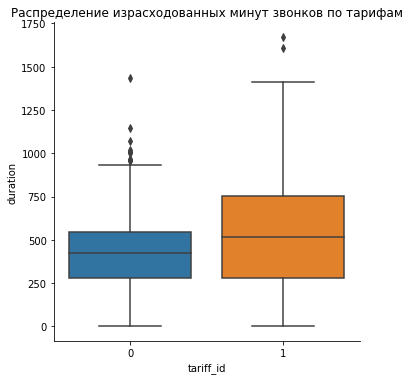

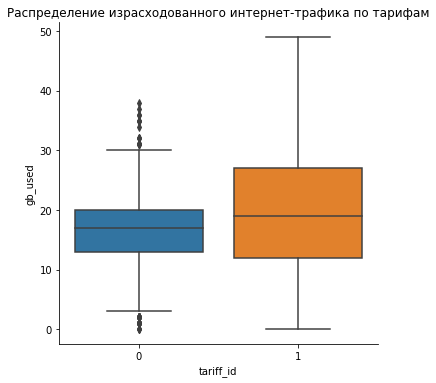

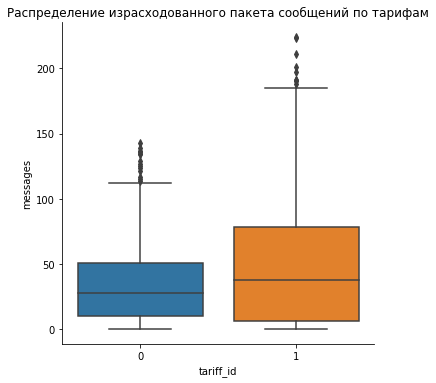

In [42]:
for column in [['duration', 'Распределение израсходованных минут звонков по тарифам'], 
               ['gb_used', 'Распределение израсходованного интернет-трафика по тарифам'], 
               ['messages', 'Распределение израсходованного пакета сообщений по тарифам']]:    
    sb.catplot(kind="box", x="tariff_id", y=column[0], data=all_services, orient='v', dodge=False)
    title = plt.title(column[1])

In [ ]:
def plot (DF, column, title):
    for tariff in range(2):
        sb.distplot(DF.query('tariff_id == @tariff')[column], kde=False)
    names = plt.legend(['smart', 'ultra'])
    title = plt.title(title)

/opt/conda/lib/python3.9/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/opt/conda/lib/python3.9/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


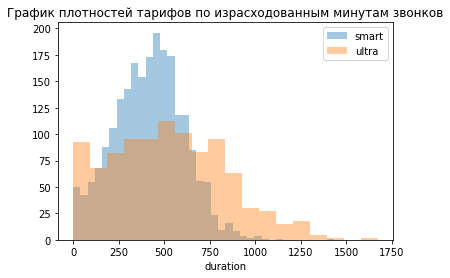

/opt/conda/lib/python3.9/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/opt/conda/lib/python3.9/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


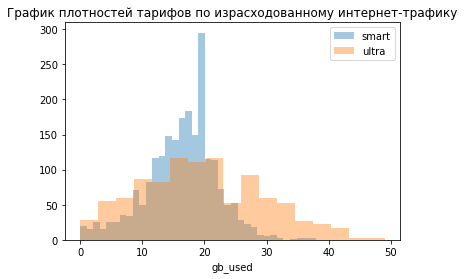

/opt/conda/lib/python3.9/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/opt/conda/lib/python3.9/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


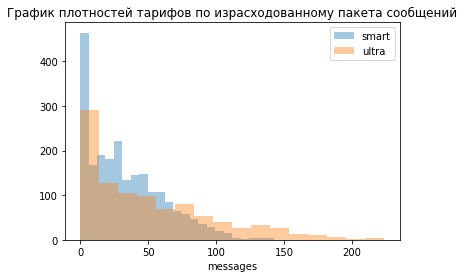

In [43]:
for column in [['duration', 'График плотностей тарифов по израсходованным минутам звонков'], 
               ['gb_used', 'График плотностей тарифов по израсходованному интернет-трафику'], 
               ['messages', 'График плотностей тарифов по израсходованному пакета сообщений']]:    
    plot(all_services, column[0], column[1])
    plt.show()

[К оглавлению](#contents)

### **Выводы** 

<a id='data_research_summary'></a>

* из графиков распределения видно, что размах между квартилями у тарифа «Ультра» шире, что также хорошо видно на графиках плотностей, свидетельствует о большем разбросе и неоднородности среди клиентов, чем у тарифа «Смарт». 

Объяснить такую статистику можно поведением пользователей, подключающих более дорогой тариф, что говорит о желании комфортно бесконтрольно пользоваться услугами связи, не обращая внимания на ограничения временем разговора. 

Не исключено, что часть из пользователей являются корпоративными клиентами, которые оформляют тарифы для своих сотрудников на комфортных условиях. Необходимо уточнить данную информацию у источника данных. 

Люди же, использующие «Смарт» тариф скорее всего ставят перед собой рамки ограничения покупаемого пакета услуг, потому что при полном израсходовании трафика дополнительный взнос на продление обычно составляет большую цену, нежели приобретение пакетом.

* клиенты с тарифом «Ультра» более осознанно тратят предоставляемые пакеты услуг и редко перевлачивают (их средний ценник составляет 1950 рублей как в договоре), однако клиенты с тарифом «Смарт» часто выходят за рамки пакетных услуг, что приводит к большим тратам на дополнительные услуги и расширения (их средний ценник составляет чуть больше 1200 рублей против 550 о договору);
* согласно статистике тариф «Смарт» приносит больше прибыли бизнесу за счет активного привлечения новых клиентов и частому превышению лимитов, в среднем человек в месяц тратит больше 1200 рублей вместо 550 по тарифу. Однако такое поведениепользователей очень непостоянное и со временем будет увеличивать недовольство тарифной политикой.

[К оглавлению](#contents)

## **IV. Проверка гипотез**
<a id='hypothesis_check'></a>


По результатам полученных статистических данных и их анализа осталось проверить несколько гипотез:
1. средняя выручка пользователей тарифов «Ультра» и «Смарт» различаются;
2. средняя выручка пользователей из Москвы отличается от выручки пользователей из других регионов.

In [44]:
def hypothesis_equal_check (array1, array2, alpha):
    alpha = 0.05
    array1 = array1['revenue']
    array2 = array2['revenue']
    results = st.ttest_ind(array2, array1, equal_var = False)
    
    print('P-value:', results.pvalue)
    
    if (results.pvalue < alpha):
        print("Отвергаем нулевую гипотезу")
    else:
        print("Не получилось отвергнуть нулевую гипотезу")

[К оглавлению](#contents)

### 1. Гипотеза: средняя выручка пользователей тарифов «Ультра» и «Смарт» различаются
<a id='hypothesis_1'></a>

* За **нулевую гипотезу H(0)** примем утверждение, что средняя выручка пользователей тарифов «Ультра» и «Смарт» **равны**.
* В качестве **альтернативной гипотезы H(1)** представим **двустороннюю** - средние выручки тарифов **различаются**.
* Критический уровень значимости зададим 5%.

In [45]:
hypothesis_equal_check(smart_per_month, ultra_per_month, .05)

P-value: 8.744897687035538e-17
Отвергаем нулевую гипотезу


Значение p-value говорит нам о малой вероятности случайности результатов, что дает основание отвергнуть предположение об отсутствии различий между двумя выручками двух тарифов (отвергнуть нулевую гипотезу).

[К оглавлению](#contents)

### 2. Гипотеза: средняя выручка пользователей из Москвы отличается от выручки пользователей из других регионов
<a id='hypothesis_2'></a>

* За **нулевую гипотезу H(0)** примем утверждение, что средняя выручка пользователей из Москвы **равна** выручке пользователей из других регионов.
* В качестве **альтернативной гипотезы H(1)** представим **двустороннюю** - средняя выручка пользователей Москвы и других регионов **различается**.
* Критический уровень значимости зададим 5%.

In [46]:
citys = all_services.merge(users.loc[: , ['user_id', 'city']], on='user_id')

moscow = citys.query('city == "Москва"')
regions = citys.query('city != "Москва"')

In [47]:
hypothesis_equal_check(moscow, regions, .05)

P-value: 0.5216952110000279
Не получилось отвергнуть нулевую гипотезу


Большое значение p-value указывает, что наблюдаемая разница в 52% случаях может быть результатом случайности. Данная вероятность слишком большая, чтобы отвергнуть предположение об отсутствии различий между средней выручкой Москвы и других регионов.

[К оглавлению](#contents)

In [48]:
display(tariff_average)

,tariff_id,age_group,duration,gb_used,messages,revenue
0,0,взрослые,411.8,16.3,32.7,"1,289.2"
1,0,пенсионеры,444.0,16.4,36.5,"1,291.8"
2,1,взрослые,519.1,19.2,51.2,"2,076.1"
3,1,пенсионеры,553.6,20.6,42.0,"2,046.0"


## **V. Итоги исследования**

<a id='summary'></a>

На основании предоставленной клиентской базы федерального оператора сотовой связи «Мегалайн» было проведено сравнительное исследование двух перспективных тарифных плана: «Смарт» и «Ультра» - для определения наиболее прибыльного для бизнеса, которое следует продвигать среди клиентов за счет маркетинговых кампаний.

По результатам основных показателей каждого тарифа установлено, что:

* клиенты с тарифом «Ультра» более осознанно тратят предоставляемые пакеты услуг и редко перевлачивают (их средний ценник составляет 1950 рублей как в договоре), однако клиенты с тарифом «Смарт» часто выходят за рамки пакетных услуг, что приводит к большим тратам на дополнительные услуги и расширения (их средний ценник составляет чуть больше 1200 рублей против 550 о договору);
* выход за рамки тарифного плана или наоборот не полное его исчерпывание приводит к достаточно большому оттоку пользователей:
    - при значительном росте почти до 130 пользователей для тарифа «Ультра» отток составил 13 юзеров (~10%), при этом для «Смарт» их стало свыше 340 с оттоком в 22 юзера (всего 6%). Получается, что людей на более дорогом тарифе не устраивает их завышенные лимиты, которых они чаще всего не достигают: в среднем телефонные разговоры длятся 526 минут вместо 3000, смс отправляется около 49 вместо 1000, а интернет трафика тратится около 19 Гб (по тарифу 30). На «Смарт» же люди часто выходят за рамки тарифного интернет плана в 15 Гб, используя 16 и выше. 
* согласно статистике тариф «Смарт» приносит больше прибыли бизнесу за счет активного привлечения новых клиентов и частому превышению лимитов, в среднем человек в месяц тратит больше 1200 рублей вместо 550 по тарифу. Однако такое поведениепользователей очень непостоянное и со временем будет увеличивать недовольство тарифной политикой.
* оператору сотовой связи «Мегалайн» с целью получения большей прибыли выгоднее пересмотреть существующие тарифные планы и вложиться в маркетинговую кампанию по их обновленным версиям: чтобы сохранить клиентов, готовых заплатить больше с «Ультра» и постоянно переплачивающих с «Смарт», достаточно ввести новый товар с увеличенным интернет трафиком и возможно регулируемыми настройками СМС-звонки. Это позволит снизить уровень недовольства путем предоставления пользователям осознанного выбора их активности при сохранении показателей прибыли
* некоторые пользователи не пользуются теми или инами сервисами:
    - SMS: 74 юзера;
    - интернетом: 3 юзера;
    - звонками: 8 юзеров;
    - ни одним из сервисов за рассмотренный период: 2 юзера.
* взрослые люди (до 65) чаще предпочитают тариф «Смарт» 
* по [статистике](#additional) люди пенсионного возрастна больше используют интернет (необъяснимый статистический факт =)) и на том и на другом тарифе, сообщений примерно одно и то же количество ~35 в месяц (тариф «Смарт»), а вот разговаривают по телефону дольше взрослых (до 65), которые на тарифе «Смарт» еще и СМС сообщениями чаще перекидываются

---

На основании данных, предоставленных оператором, мы проверили две гипотезы и установили:

---

**1. Гипотеза: Средняя выручка пользователей тарифов «Ультра» и «Смарт» различаются**.

В ходе анализа выявили малую вероятность случайности результатов, что дает основание ***отвергнуть предположение об отсутствии различий между двумя выручками двух тарифов***.

---

**2. Гипотеза: Средняя выручка пользователей из Москвы отличается от выручки пользователей из других регионов.**

По полученным данным сделали вывод:

Наблюдаемая разница между средней выручки Москвы и регионов в 52% случаях может быть результатом случайности. Данная вероятность **слишком большая, чтобы отвергнуть предположение об отсутствии различий между средней выручкой Москвы и других регионов**


---

**Помимо этого в ходе исследования была выполнена [обработка исходных данных](#data_moderation_summary) для удобства анализа.**

[К оглавлению](#contents)